In [1]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.0 MB/s eta 0:00:00


## Prepare environment and fetch appropriate SAM model

In [2]:
import random
import numpy as np
import torch

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything()


In [3]:
to_evaluate = 'eds20'


RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
  from google.colab import drive
  drive.mount('/gdrive')

  WORKING_PATH = "cloud/path/to/folder/"
  RESULTS_PATH = "cloud/path/to/folder/results/"
  DATA_PATH = "cloud/path/to/dataset/"

else:
  WORKING_PATH = "local/path/to/folder/"
  RESULTS_PATH = "local/path/to/folder/results/"
  DATA_PATH = "local/path/to/dataset/"

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
import os
HOME = os.getcwd()
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

Mounted at /gdrive
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-tqoa82wm
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-tqoa82wm
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=0d729a81d75f26fc5685922401ec3ef209fa4225a6da8eb40dd9d93fe0f7337b
  Stored in directory: /tmp/pip-ephem-wheel-cache-odgoe6j8/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━

In [4]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_b_01ec64.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_b_01ec64.pth ; exist: True


In [5]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_b"

In [6]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [7]:
mask_predictor = SamPredictor(sam)
mask_generator = SamAutomaticMaskGenerator(sam)

In [8]:
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

## Own funcs

In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return
    # sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((anns[0].shape[0], anns[0].shape[1], 4))
    img[:,:,3] = 0
    for ann in anns:
        m = ann
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_bounding_box(image, min_coords, max_coords, color='red'):
    image_with_bbox = np.copy(image)

    y_min, x_min = min_coords
    y_max, x_max = max_coords

    plt.imshow(image_with_bbox, cmap='gray') 
    plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                      fill=False, edgecolor=color, linewidth=2))

    plt.axis('off') 
    plt.show()

In [10]:
import numpy as np

def get_bounding_box(mask, enlarge=0):
    nonzero_coords = np.argwhere(mask)

    if len(nonzero_coords) == 0:
        return None

    min_coords = np.min(nonzero_coords, axis=0)
    max_coords = np.max(nonzero_coords, axis=0)

    min_coords -= enlarge
    max_coords += enlarge

    min_coords = np.maximum(min_coords, [0, 0])
    max_coords = np.minimum(max_coords, [mask.shape[0] - 1, mask.shape[1] - 1])

    return min_coords, max_coords

In [ ]:
import numpy as np

def sample_n_coordinates_from_mask(mask, n, sample_inside=True):
    y_coords, x_coords = np.where(mask)

    if sample_inside:
        if len(x_coords) > 0:
            n = min(n, len(x_coords))

            random_indices = np.random.choice(len(x_coords), n, replace=False)
            random_coordinates = [(x_coords[i], y_coords[i]) for i in random_indices]

            return random_coordinates
        else:
            return [] 
    else:
        mask_shape = mask.shape
        coordinates_outside_mask = []

        while n > 0:
            x = np.random.randint(0, mask_shape[1])
            y = np.random.randint(0, mask_shape[0])

            if mask[y, x] == 0:  
                coordinates_outside_mask.append((x, y))
                n -= 1

        return coordinates_outside_mask

In [17]:
def conformity_coefficient(TP, FP, FN):
    if TP > 0:
        return 1 - (FP + FN) / TP
    else:
        return 0

def manual_center_of_mass(mask):
    y_coords, x_coords = np.where(mask)

    if len(x_coords) > 0 and len(y_coords) > 0:
        center_x = int(np.mean(x_coords))
        center_y = int(np.mean(y_coords))
        return (center_x, center_y)
    else:
        return None  


In [12]:
import pickle
import random
import cv2
import os
import numpy as np

def get_eds20(dataset_path, n_files=None, shuffle=False, dropblinks=False):
    fnames = []

    imgs_uncropped = []
    masks_uncropped = []

    with open(
            dataset_path + "test_sampleName_GT.pkl",
            "rb") as f:
        test_set = pickle.load(f)


    with open(os.path.join(dataset_path,  "labels.txt")) as f:
      lines = f.readlines()

      if shuffle:
          random.shuffle(lines)
      if n_files:
          lines = lines[:n_files]

      for l in lines:
        l = l.strip()

        id = l.split("/")[-1].split("_")[-1][:-4]
        im = os.path.join(dataset_path, l.split("/")[0], f"{id}.png")
        im = cv2.imread(im)
        # im = cv2.imread(im, cv2.IMREAD_GRAYSCALE)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

        mask = np.load(os.path.join(dataset_path,  f"{l}"))

        fnames.append(l)
        imgs_uncropped.append(im)
        masks_uncropped.append(mask)


    for i, (k, mask) in enumerate(test_set.items()):
        id = k.split("/")[-1].split("_")[-1][:-4]
        im = os.path.join(dataset_path, k.split("/")[0], f"{id}.png")
        im = cv2.imread(im)
        # im = cv2.imread(im, cv2.IMREAD_GRAYSCALE)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

        fnames.append(k)
        imgs_uncropped.append(im)
        masks_uncropped.append(mask)

        if n_files and i >= n_files:
          break

    return fnames, imgs_uncropped, masks_uncropped


In [13]:
import pathlib

def get_eds19(dataset_path, up_to_n_files=None):
  dataset_path = pathlib.Path(dataset_path)
  imgfs = (dataset_path/'images').glob("*.png")

  imgs = []
  labels = []
  names = []
  if up_to_n_files:
      imgfs = list(imgfs)[:up_to_n_files]
  for f in imgfs:
      im = cv2.imread(str(f))
      im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
      l = np.load(dataset_path/'labels'/(f.stem +'.npy')) #== 3

      imgs.append(im)
      labels.append(l)
      names.append(f.name)

  return names, imgs, labels


## Evaluation according to prompting strategies

### Load dataset

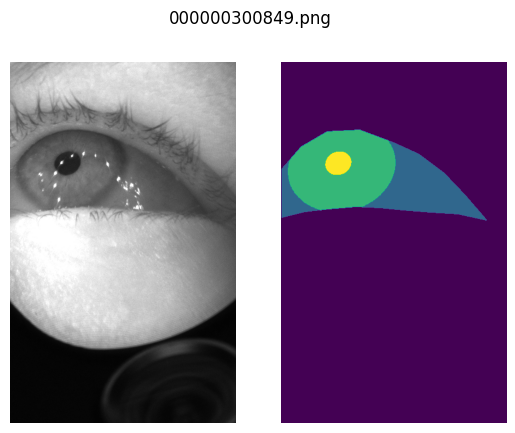

In [16]:
import matplotlib.pyplot as plt

fnames, imgs_uncropped, masks_uncropped = get_eds19(DATA_PATH)

fig, axs = plt.subplots(1,2)

plt.suptitle(fnames[0])
axs[0].imshow(imgs_uncropped[0])
axs[1].imshow(masks_uncropped[0])

for a in axs.ravel():
  a.axis('off')

### Set label constants (consistent with EDS19/20) and import packages

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import torch
from monai.metrics import SurfaceDistanceMetric, HausdorffDistanceMetric, DiceMetric, compute_iou, ConfusionMatrixMetric
from monai.transforms import Compose, ToTensor
import matplotlib.patches as patches


SCLERA = 1
IRIS = 2
PUPIL = 3

### P1

In [ ]:
def calculate_metrics(class_label, ma, im, fn, mask_predictor, sample, do_plot=False):
    label = ma == class_label

    transforms = Compose([ToTensor()])
    monai_metrics = {
        "DSC": DiceMetric(include_background=False), 
        "HD": HausdorffDistanceMetric(),
        "ASSD": SurfaceDistanceMetric(symmetric=True),
        "IOU": compute_iou,
    }

    if label.sum() > 0:
        point_prompt = np.array(sample_n_coordinates_from_mask(label, sample, sample_inside=True))
        point_labels = np.ones(sample)

        masks, scores, logits = mask_predictor.predict(
            point_coords=point_prompt,
            point_labels=point_labels,
            multimask_output=False)

        prediction = masks[0]

        if do_plot:

          fig, ax = plt.subplots(1,3)
          ax[0].imshow(im, cmap='gray')
          ax[1].imshow(prediction, cmap='gray')
          ax[2].imshow(label, cmap='gray')
          ax[0].scatter(*point_prompt[0], s=10)

          for a in ax.ravel():
            a.axis('off')

          plt.show()


        ma = np.expand_dims(ma, axis=0)
        ma = torch.Tensor(ma)

        input_data = {'mask': ma == class_label}
        input_data = transforms(input_data)
        ma = input_data['mask']

        prediction_tensor = torch.Tensor(prediction)
        prediction_tensor = prediction_tensor.unsqueeze(0).unsqueeze(0)  

        ma = ma.unsqueeze(0) 

        metrics = {}
        for metric_name, metric_fn in monai_metrics.items():
            result = metric_fn(prediction_tensor, ma)
            metrics[metric_name] = result.item()

        prediction_binary = (prediction_tensor > 0).int()
        ground_truth_binary = (ma > 0).int()
        TP = (prediction_binary * ground_truth_binary).sum().item()
        FP = (prediction_binary * (1 - ground_truth_binary)).sum().item()
        FN = ((1 - prediction_binary) * ground_truth_binary).sum().item()

        cc = conformity_coefficient(TP, FP, FN)

        current_metrics_df = pd.DataFrame({'Filename': [fn],
                                           'DICE⬆': [metrics['DSC']],
                                           'JAC⬆': [metrics['IOU']],
                                           'HD⬇': [metrics['HD']],
                                           'ASD⬇': [metrics['ASSD']],
                                           'CON⬆': [cc]})

        return current_metrics_df

    else:
        print(f"{fn} has an empty {class_label} mask")
        return None


In [19]:
STRAT = 'P1'
SAMPLE = 1

class_labels = [PUPIL, SCLERA, IRIS]
class_names = ['pupil', 'sclera', 'iris']
class_metrics_dfs = {}

for class_name in class_names:
    class_metrics_dfs[class_name] = []


for fn, im, ma in zip(fnames, imgs_uncropped, masks_uncropped):
    mask_predictor.set_image(im)

    for class_label, class_name in zip(class_labels, class_names):
        current_metrics_df = calculate_metrics(class_label, ma, im, fn, mask_predictor, SAMPLE, do_plot=False)

        if current_metrics_df is not None:
            class_metrics_dfs[class_name].append(current_metrics_df)

for class_name, class_metrics_df in class_metrics_dfs.items():
    combined_metrics_df = pd.concat(class_metrics_df, ignore_index=True)
    combined_metrics_df.to_csv(RESULTS_PATH + f'{class_name}_{STRAT}_{to_evaluate}_{MODEL_TYPE}.csv', index=False)


000000303582.png has an empty 3 mask
000000306305.png has an empty 3 mask
000000292540.png has an empty 3 mask


### P4


In [ ]:
STRAT = 'P4'
SAMPLE = 4

class_labels = [PUPIL, SCLERA, IRIS]
class_names = ['pupil', 'sclera', 'iris']
class_metrics_dfs = {}

for class_name in class_names:
    class_metrics_dfs[class_name] = []


for fn, im, ma in zip(fnames, imgs_uncropped, masks_uncropped):
    mask_predictor.set_image(im)

    for class_label, class_name in zip(class_labels, class_names):
        current_metrics_df = calculate_metrics(class_label, ma, im, fn, mask_predictor, SAMPLE, do_plot=False)

        if current_metrics_df is not None:
            class_metrics_dfs[class_name].append(current_metrics_df)

for class_name, class_metrics_df in class_metrics_dfs.items():
    combined_metrics_df = pd.concat(class_metrics_df, ignore_index=True)
    combined_metrics_df.to_csv(RESULTS_PATH + f'{class_name}_{STRAT}_{to_evaluate}_{MODEL_TYPE}.csv', index=False)


### P4-4


In [ ]:
def calculate_metrics(class_label, ma, im, mask_predictor, sample, do_plot=False):
    label = ma == class_label

    transforms = Compose([ToTensor()])
    monai_metrics = {
        "DSC": DiceMetric(include_background=False), 
        "HD": HausdorffDistanceMetric(),
        "ASSD": SurfaceDistanceMetric(symmetric=True),
        "IOU": compute_iou,
    }

    if label.sum() > 0:
        pos_points = sample_n_coordinates_from_mask(label, sample, sample_inside=True)
        neg_points = sample_n_coordinates_from_mask(label, sample, sample_inside=False, restrict_area=True)
        point_prompt = np.array(pos_points + neg_points)
        point_labels = np.hstack([np.ones(sample), np.zeros(sample)])

        masks, scores, logits = mask_predictor.predict(
            point_coords=point_prompt,
            point_labels=point_labels,
            multimask_output=False)

        prediction = masks[0]

        if do_plot:

          fig, ax = plt.subplots(1,3)
          ax[0].imshow(im, cmap='gray')
          ax[1].imshow(prediction, cmap='gray')
          ax[2].imshow(label, cmap='gray')
          ax[0].scatter(*point_prompt[:4].T, s=10, c='blue')
          ax[0].scatter(*point_prompt[4:].T, s=10, c='red')


          for a in ax.ravel():
            a.axis('off')

          plt.show()


        ma = np.expand_dims(ma, axis=0)
        ma = torch.Tensor(ma)

        input_data = {'mask': ma == class_label}
        input_data = transforms(input_data)
        ma = input_data['mask']

        prediction_tensor = torch.Tensor(prediction)
        prediction_tensor = prediction_tensor.unsqueeze(0).unsqueeze(0)  

        ma = ma.unsqueeze(0) 

        metrics = {}
        for metric_name, metric_fn in monai_metrics.items():
            result = metric_fn(prediction_tensor, ma)
            metrics[metric_name] = result.item()

        prediction_binary = (prediction_tensor > 0).int()
        ground_truth_binary = (ma > 0).int()
        TP = (prediction_binary * ground_truth_binary).sum().item()
        FP = (prediction_binary * (1 - ground_truth_binary)).sum().item()
        FN = ((1 - prediction_binary) * ground_truth_binary).sum().item()

        cc = conformity_coefficient(TP, FP, FN)

        current_metrics_df = pd.DataFrame({'Filename': [fn],
                                           'DICE⬆': [metrics['DSC']],
                                           'JAC⬆': [metrics['IOU']],
                                           'HD⬇': [metrics['HD']],
                                           'ASD⬇': [metrics['ASSD']],
                                           'CON⬆': [cc]})

        return current_metrics_df

    else:
        print(f"{fn} has an empty {class_label} mask")
        return None

In [ ]:
SAMPLE = 4
STRAT = 'P4-4'

class_labels = [PUPIL, SCLERA, IRIS]
class_names = ['pupil', 'sclera', 'iris']


class_metrics_dfs = {}
for class_name in class_names:
    class_metrics_dfs[class_name] = []

for fn, im, ma in zip(fnames, imgs_uncropped, masks_uncropped):
    mask_predictor.set_image(im)
    print(fn)
    for class_label, class_name in zip(class_labels, class_names):

        try:
            current_metrics_df = calculate_metrics(class_label, ma, im, mask_predictor, SAMPLE, do_plot=False)
        except:
            print(f'Failed {fn} for {class_name}')
            continue

        if current_metrics_df is not None:
            class_metrics_dfs[class_name].append(current_metrics_df)

for class_name, class_metrics_df in class_metrics_dfs.items():
    combined_metrics_df = pd.concat(class_metrics_df, ignore_index=True)
    combined_metrics_df.to_csv(RESULTS_PATH + f'{class_name}_{STRAT}_{to_evaluate}_{MODEL_TYPE}.csv', index=False)



### BBOX


In [ ]:
def calculate_metrics(class_label, ma, im, mask_predictor):
    label = ma == class_label
    bbox = get_bounding_box(label, enlarge=0)

    transforms = Compose([ToTensor()])
    monai_metrics = {
    "DSC": DiceMetric(include_background=False),  
    "HD": HausdorffDistanceMetric(),
    "ASSD": SurfaceDistanceMetric(symmetric=True),
    "IOU": compute_iou,
    }
    if bbox is not None:
        box = np.array([*bbox[0][::-1], *bbox[1][::-1]])

        masks, scores, logits = mask_predictor.predict(box=box, multimask_output=False)
        prediction = masks[0]

        ma = np.expand_dims(ma, axis=0)
        ma = torch.Tensor(ma)

        input_data = {'mask': ma == class_label}
        input_data = transforms(input_data)
        ma = input_data['mask']

        prediction_tensor = torch.Tensor(prediction)
        prediction_tensor = prediction_tensor.unsqueeze(0).unsqueeze(0) 

        ma = ma.unsqueeze(0)  

        metrics = {}
        for metric_name, metric_fn in monai_metrics.items():
            result = metric_fn(prediction_tensor, ma)
            metrics[metric_name] = result.item()

        prediction_binary = (prediction_tensor > 0).int()
        ground_truth_binary = (ma > 0).int()
        TP = (prediction_binary * ground_truth_binary).sum().item()
        FP = (prediction_binary * (1 - ground_truth_binary)).sum().item()
        FN = ((1 - prediction_binary) * ground_truth_binary).sum().item()

        cc = conformity_coefficient(TP, FP, FN)

        current_metrics_df = pd.DataFrame({'Filename': [fn],
                                           'DICE⬆': [metrics['DSC']],
                                           'JAC⬆': [metrics['IOU']],
                                           'HD⬇': [metrics['HD']],
                                           'ASD⬇': [metrics['ASSD']],
                                           'CON⬆': [cc]})

        return current_metrics_df

    else:
        print(f"{fn} has an empty {class_label} mask")
        return None

In [ ]:
STRAT = 'BBOX'

class_labels = [PUPIL, SCLERA, IRIS]
class_names = ['pupil', 'sclera', 'iris']
class_metrics_dfs = {}

for class_name in class_names:
    class_metrics_dfs[class_name] = []


for fn, im, ma in zip(fnames, imgs_uncropped, masks_uncropped):
    mask_predictor.set_image(im)

    for class_label, class_name in zip(class_labels, class_names):
        current_metrics_df = calculate_metrics(class_label, ma, im, mask_predictor)

        if current_metrics_df is not None:
            class_metrics_dfs[class_name].append(current_metrics_df)

for class_name, class_metrics_df in class_metrics_dfs.items():
    combined_metrics_df = pd.concat(class_metrics_df, ignore_index=True)
    combined_metrics_df.to_csv(RESULTS_PATH + f'{class_name}_{STRAT}_{to_evaluate}_{MODEL_TYPE}.csv', index=False)


### BBOXP1

In [ ]:

def calculate_metrics(class_label, ma, im, mask_predictor, sample, do_plot=False):
    label = ma == class_label
    bbox = get_bounding_box(label, enlarge=0)

    transforms = Compose([ToTensor()])
    monai_metrics = {
    "DSC": DiceMetric(include_background=False), 
    "HD": HausdorffDistanceMetric(),
    "ASSD": SurfaceDistanceMetric(symmetric=True),
    "IOU": compute_iou,
    }
    if bbox is not None:
        box = np.array([*bbox[0][::-1], *bbox[1][::-1]])

        point_prompt = np.array(sample_n_coordinates_from_mask(label, sample, sample_inside=True))
        point_labels = np.ones(sample)

        masks, scores, logits = mask_predictor.predict(
            box=box,
            point_coords=point_prompt,
            point_labels=point_labels,
            multimask_output=False)
        prediction = masks[0]

        if do_plot:

          fig, ax = plt.subplots(1,3)
          ax[0].imshow(im, cmap='gray')
          ax[1].imshow(prediction, cmap='gray')
          ax[2].imshow(label, cmap='gray')
          ax[0].scatter(*point_prompt[:4].T, s=10, c='blue')
          ax[0].scatter(*point_prompt[4:].T, s=10, c='red')

          x1, y1, x2, y2 = box
          width = x2 - x1
          height = y2 - y1
          rectangle = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
          ax[0].add_patch(rectangle)

          for a in ax.ravel():
            a.axis('off')

        ma = np.expand_dims(ma, axis=0)
        ma = torch.Tensor(ma)

        input_data = {'mask': ma == class_label}
        input_data = transforms(input_data)
        ma = input_data['mask']

        prediction_tensor = torch.Tensor(prediction)
        prediction_tensor = prediction_tensor.unsqueeze(0).unsqueeze(0)

        ma = ma.unsqueeze(0)  

        metrics = {}
        for metric_name, metric_fn in monai_metrics.items():
            result = metric_fn(prediction_tensor, ma)
            metrics[metric_name] = result.item()

        prediction_binary = (prediction_tensor > 0).int()
        ground_truth_binary = (ma > 0).int()
        TP = (prediction_binary * ground_truth_binary).sum().item()
        FP = (prediction_binary * (1 - ground_truth_binary)).sum().item()
        FN = ((1 - prediction_binary) * ground_truth_binary).sum().item()

        cc = conformity_coefficient(TP, FP, FN)

        current_metrics_df = pd.DataFrame({'Filename': [fn],
                                           'DICE⬆': [metrics['DSC']],
                                           'JAC⬆': [metrics['IOU']],
                                           'HD⬇': [metrics['HD']],
                                           'ASD⬇': [metrics['ASSD']],
                                           'CON⬆': [cc]})

        return current_metrics_df

    else:
        print(f"{fn} has an empty {class_label} mask")
        return None

In [ ]:
SAMPLE = 1
STRAT = 'BBOXP1'

class_labels = [PUPIL, SCLERA, IRIS]
class_names = ['pupil', 'sclera', 'iris']
class_metrics_dfs = {}

for class_name in class_names:
    class_metrics_dfs[class_name] = []


for fn, im, ma in zip(fnames, imgs_uncropped, masks_uncropped):
    mask_predictor.set_image(im)

    for class_label, class_name in zip(class_labels, class_names):
        current_metrics_df = calculate_metrics(class_label, ma, im, mask_predictor, SAMPLE, do_plot=False)

        if current_metrics_df is not None:
            class_metrics_dfs[class_name].append(current_metrics_df)

for class_name, class_metrics_df in class_metrics_dfs.items():
    combined_metrics_df = pd.concat(class_metrics_df, ignore_index=True)
    combined_metrics_df.to_csv(RESULTS_PATH + f'{class_name}_{STRAT}_{to_evaluate}_{MODEL_TYPE}.csv', index=False)


### BBOXP4

In [ ]:
STRAT = 'BBOXP4'
SAMPLE = 4

class_labels = [PUPIL, SCLERA, IRIS]
class_names = ['pupil', 'sclera', 'iris']
class_metrics_dfs = {}

for class_name in class_names:
    class_metrics_dfs[class_name] = []


for fn, im, ma in zip(fnames, imgs_uncropped, masks_uncropped):
    mask_predictor.set_image(im)

    for class_label, class_name in zip(class_labels, class_names):
        current_metrics_df = calculate_metrics(class_label, ma, im, mask_predictor, SAMPLE, do_plot=False)

        if current_metrics_df is not None:
            class_metrics_dfs[class_name].append(current_metrics_df)

for class_name, class_metrics_df in class_metrics_dfs.items():
    combined_metrics_df = pd.concat(class_metrics_df, ignore_index=True)
    combined_metrics_df.to_csv(RESULTS_PATH + f'{class_name}_{STRAT}_{to_evaluate}_{MODEL_TYPE}.csv', index=False)


### BBOXP1-1

In [ ]:
def calculate_metrics(class_label, ma, im, mask_predictor, sample, do_plot=False):
    label = ma == class_label
    bbox = get_bounding_box(label, enlarge=0)

    transforms = Compose([ToTensor()])
    monai_metrics = {
    "DSC": DiceMetric(include_background=False), 
    "HD": HausdorffDistanceMetric(),
    "ASSD": SurfaceDistanceMetric(symmetric=True),
    "IOU": compute_iou,
    }
    if bbox is not None:
        box = np.array([*bbox[0][::-1], *bbox[1][::-1]])
        pos_point = sample_n_coordinates_from_mask(label,  sample, sample_inside=True)
        if class_label == SCLERA:
          neg_point = sample_n_coordinates_from_mask(ma == IRIS, sample, sample_inside=True)
        elif class_label == IRIS:
          neg_point = sample_n_coordinates_from_mask(ma == PUPIL,  sample, sample_inside=True)
        else:
          raise Exception("We're just focusing on SCLERA and IRIS in this experiment...")

        point_prompt = np.array(pos_point + neg_point)
        point_labels = np.hstack([np.ones(sample), np.zeros(sample)])

        masks, scores, logits = mask_predictor.predict(
            box=box,
            point_coords=point_prompt,
            point_labels=point_labels,
            multimask_output=False)
        prediction = masks[0]

        if do_plot:

          fig, ax = plt.subplots(1,3)
          ax[0].imshow(im, cmap='gray')
          ax[1].imshow(prediction, cmap='gray')
          ax[2].imshow(label, cmap='gray')
          ax[0].scatter(*point_prompt[:sample].T, s=10, c='blue')
          ax[0].scatter(*point_prompt[sample:].T, s=10, c='red')

          x1, y1, x2, y2 = box
          width = x2 - x1
          height = y2 - y1
          rectangle = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
          ax[0].add_patch(rectangle)


          for a in ax.ravel():
            a.axis('off')

        ma = np.expand_dims(ma, axis=0)
        ma = torch.Tensor(ma)

        input_data = {'mask': ma == class_label}
        input_data = transforms(input_data)
        ma = input_data['mask']

        prediction_tensor = torch.Tensor(prediction)
        prediction_tensor = prediction_tensor.unsqueeze(0).unsqueeze(0) 

        ma = ma.unsqueeze(0)  

        metrics = {}
        for metric_name, metric_fn in monai_metrics.items():
            result = metric_fn(prediction_tensor, ma)
            metrics[metric_name] = result.item()


        prediction_binary = (prediction_tensor > 0).int()
        ground_truth_binary = (ma > 0).int()
        TP = (prediction_binary * ground_truth_binary).sum().item()
        FP = (prediction_binary * (1 - ground_truth_binary)).sum().item()
        FN = ((1 - prediction_binary) * ground_truth_binary).sum().item()

        cc = conformity_coefficient(TP, FP, FN)

        current_metrics_df = pd.DataFrame({'Filename': [fn],
                                           'DICE⬆': [metrics['DSC']],
                                           'JAC⬆': [metrics['IOU']],
                                           'HD⬇': [metrics['HD']],
                                           'ASD⬇': [metrics['ASSD']],
                                           'CON⬆': [cc]})

        return current_metrics_df

    else:
        print(f"{fn} has an empty {class_label} mask")
        return None

In [ ]:
STRAT = 'BBOXP1-1'
SAMPLE = 1

class_labels = [SCLERA, IRIS]
class_names = ['sclera', 'iris']
class_metrics_dfs = {}

for class_name in class_names:
    class_metrics_dfs[class_name] = []

for fn, im, ma in zip(fnames, imgs_uncropped, masks_uncropped):
    print(f"{fn}")
    mask_predictor.set_image(im)

    for class_label, class_name in zip(class_labels, class_names):
        if class_label == IRIS:
          pupil_mask = ma == PUPIL
          if np.sum(pupil_mask) == 0:
            print(f'No pupil mask found. Skipping iris.')
            continue
        if class_label == SCLERA:
          iris_mask = ma == IRIS
          if np.sum(iris_mask) == 0:
            print(f'No iris mask found. Skipping sclera.')
            continue

        current_metrics_df = calculate_metrics(class_label, ma, im, mask_predictor, SAMPLE, do_plot=False)

        if current_metrics_df is not None:
            class_metrics_dfs[class_name].append(current_metrics_df)

for class_name, class_metrics_df in class_metrics_dfs.items():
    combined_metrics_df = pd.concat(class_metrics_df, ignore_index=True)
    combined_metrics_df.to_csv(RESULTS_PATH + f'{class_name}_{STRAT}_{to_evaluate}_{MODEL_TYPE}.csv', index=False)

### BBOXP4-4

In [ ]:
STRAT = 'BBOXP4-4'
SAMPLE = 4

class_labels = [SCLERA, IRIS]
class_names = ['sclera', 'iris']
class_metrics_dfs = {}

for class_name in class_names:
    class_metrics_dfs[class_name] = []


for fn, im, ma in zip(fnames, imgs_uncropped, masks_uncropped):
    print(f"{fn}")
    mask_predictor.set_image(im)

    for class_label, class_name in zip(class_labels, class_names):
        if class_label == IRIS:
          pupil_mask = ma == PUPIL
          if np.sum(pupil_mask) == 0:
            print(f'No pupil mask found. Skipping iris.')
            continue
        if class_label == SCLERA:
          iris_mask = ma == IRIS
          if np.sum(iris_mask) == 0:
            print(f'No iris mask found. Skipping sclera.')
            continue

        current_metrics_df = calculate_metrics(class_label, ma, im, mask_predictor, SAMPLE, do_plot=False)

        if current_metrics_df is not None:
            class_metrics_dfs[class_name].append(current_metrics_df)


for class_name, class_metrics_df in class_metrics_dfs.items():
    combined_metrics_df = pd.concat(class_metrics_df, ignore_index=True)
    combined_metrics_df.to_csv(RESULTS_PATH + f'{class_name}_{STRAT}_{to_evaluate}_{MODEL_TYPE}.csv', index=False)

### Everything

In [ ]:
!pip install miseval
from miseval import evaluate

In [ ]:
STRAT = 'E'

monai_metrics = {
    "DSC": DiceMetric(include_background=False), 
    "HD": HausdorffDistanceMetric(),
    "ASSD": SurfaceDistanceMetric(symmetric=True),
    "IOU": compute_iou,
}

def conformity_coefficient(TP, FP, FN):
    if TP > 0:
        return 1 - (FP + FN) / TP
    else:
        return 0

metrics_dfs = {'pupil':[], 'iris':[], 'sclera':[]}

transforms = Compose([ToTensor()])
for fn, im, ma in zip(fnames, imgs_uncropped, masks_uncropped):
    masks = mask_generator.generate(im)

    p_dices = []
    i_dices = []
    s_dices = []
    for m in masks:
        p_dices.append(evaluate(m['segmentation'], ma == PUPIL, metric="DSC"))
        i_dices.append(evaluate(m['segmentation'], ma == IRIS, metric="DSC"))
        s_dices.append(evaluate(m['segmentation'], ma == SCLERA, metric="DSC"))

    pupil_prediction = masks[np.argmax(np.array(p_dices))]
    iris_prediction = masks[np.argmax(np.array(i_dices))]
    sclera_prediction = masks[np.argmax(np.array(s_dices))]

    ma = np.expand_dims(ma, axis=0)
    ma = torch.Tensor(ma)

    input_data = {'p_mask': ma == PUPIL,
                  'i_mask': ma == IRIS,
                  's_mask': ma == SCLERA,
                  }
    input_data = transforms(input_data)


    for pred, m, feat in zip([pupil_prediction, iris_prediction, sclera_prediction],
                             ['p_mask', 'i_mask', 's_mask',],
                             ['pupil', 'iris', 'sclera']):
        ma = input_data[m]

        prediction_tensor = torch.Tensor(pred['segmentation'])
        prediction_tensor = prediction_tensor.unsqueeze(0).unsqueeze(0)  

        ma = ma.unsqueeze(0)  

        metrics = {}
        for metric_name, metric_fn in monai_metrics.items():
            result = metric_fn(prediction_tensor, ma)
            metrics[metric_name] = result.item()

        prediction_tensor = (prediction_tensor > 0).int()
        ground_truth_binary = (ma > 0).int()
        TP = (prediction_tensor * ground_truth_binary).sum().item()
        FP = (prediction_tensor * (1 - ground_truth_binary)).sum().item()
        FN = ((1 - prediction_tensor) * ground_truth_binary).sum().item()

        cc = conformity_coefficient(TP, FP, FN)

        current_metrics_df = pd.DataFrame({'Filename': [fn],
                                          'DICE⬆': [metrics['DSC']],
                                          'JAC⬆': [metrics['IOU']],
                                          'HD⬇': [metrics['HD']],
                                          'ASD⬇': [metrics['ASSD']],
                                          'CON⬆': [cc]})

        metrics_dfs[feat].append(current_metrics_df)
for feat, df in metrics_dfs.items():
    metrics_df = pd.concat(metrics_dfs[feat], ignore_index=True)
    metrics_df.to_csv(RESULTS_PATH + f'{class_name}_{STRAT}_{to_evaluate}_{MODEL_TYPE}.csv', index=False)


